In [ ]:
import numpy as np
import pandas as pd

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/train_df.csv', index_col=0)
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/test_df.csv', index_col=0)

In [ ]:
from numpy import loadtxt
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
X=train_df.drop(['reordered','eval_set'],axis=1)

In [ ]:
X.head()

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
0,1,112108,4,10,9.0,2067,1,0,NaN,3,19
1,96,17227,6,20,30.0,2067,1,0,NaN,3,19
2,3243,206024,3,15,2.0,2067,1,0,NaN,3,19
3,12950,11456,1,14,13.0,2067,1,0,0.0,3,19
4,17683,177724,5,21,0.0,2067,1,0,NaN,3,19


In [ ]:
Y = train_df['reordered']

In [ ]:
Y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: reordered, dtype: float64

разделим данные на обучающие и тестовые наборы

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)

In [ ]:
model = XGBClassifier()

In [ ]:
del X, Y

In [ ]:
train_y = train_df.reordered.values
out_df = test_df[["order_id", "product_id"]]

In [ ]:
train_df = np.array(train_df.drop(["order_id", "user_id", "reordered",'eval_set'], axis=1))
test_df = np.array(test_df.drop(["order_id", "user_id",'eval_set'], axis=1))

Обучение модели с помощью XGBClassifier

In [ ]:
model.fit(X_train, y_train)

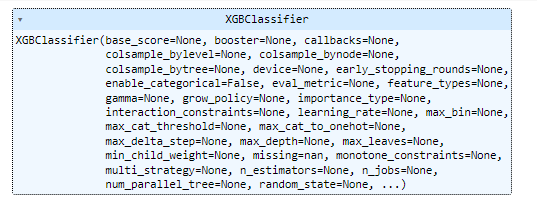

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
predictions = [round(value) for value in y_pred]

In [ ]:
accuracy = accuracy_score(y_test, predictions)

### Accuracy XGBoost Classifier

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

In [ ]:
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 90.65%


In [ ]:
print ("\n Classification report : \n", classification_report(y_test, predictions))


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.91      0.99      0.95   2522522
         1.0       0.60      0.14      0.22    274117

    accuracy                           0.91   2796639
   macro avg       0.76      0.56      0.59   2796639
weighted avg       0.88      0.91      0.88   2796639



In [ ]:
#confusion matrix
conf_matrix = confusion_matrix(y_test,predictions)
plt.figure(figsize=(12,12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt = "d",annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

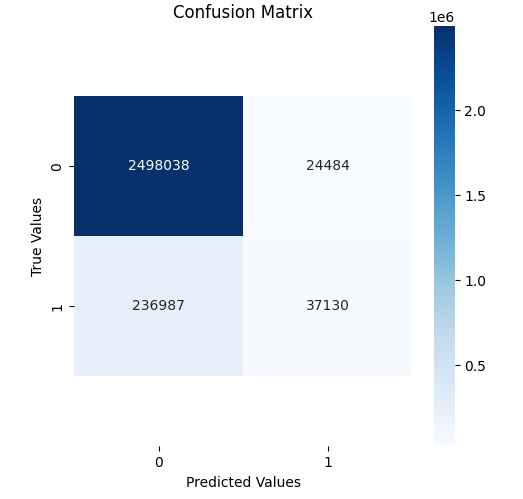

In [ ]:
#f1-score
f1 = f1_score(y_test, predictions)
print("F1 Score: ", f1)

#roc_auc_score
model_roc_auc = roc_auc_score(y_test,predictions)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,predictions)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.figure(figsize=(12,12))
plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

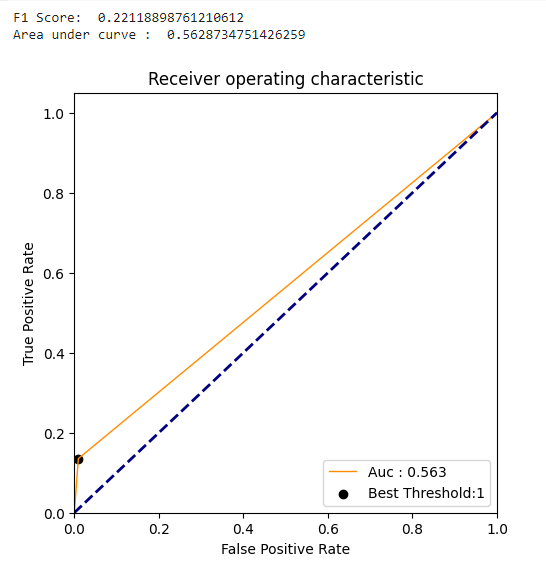

In [ ]:
fig, ax = plt.subplots(figsize = (10,8))
xgb.plot_importance(model, ax = ax)

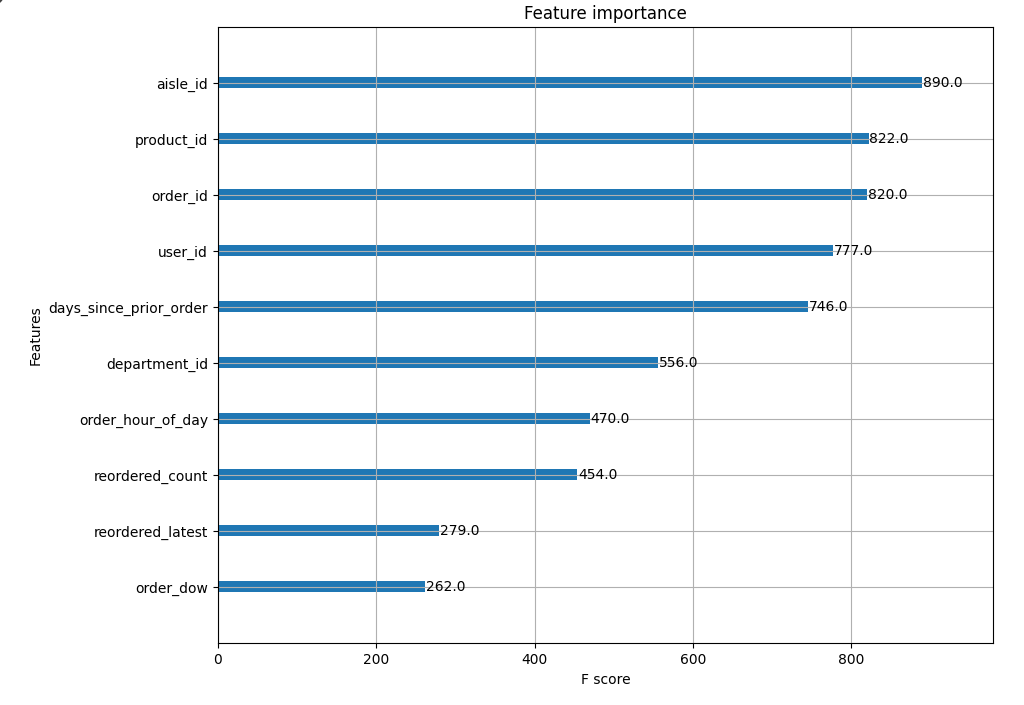

Построю XGb функцию

In [ ]:
def runXGB(train_X, train_y, test_X, test_y=None, feature_names=None, seed_val=0):
        params = {}
        params["objective"] = "binary:logistic"
        params['eval_metric'] = 'logloss'
        params["eta"] = 0.05
        params["subsample"] = 0.7
        params["min_child_weight"] = 10
        params["colsample_bytree"] = 0.7
        params["max_depth"] = 8
        params["silent"] = 1
        params["seed"] = seed_val
        num_rounds = 100
        plst = list(params.items())
        xgtrain = xgb.DMatrix(train_X, label=train_y)

        if test_y is not None:
                xgtest = xgb.DMatrix(test_X, label=test_y)
                watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
                model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=10)
        else:
                xgtest = xgb.DMatrix(test_X)
                model = xgb.train(plst, xgtrain, num_rounds)

        pred_test_y = model.predict(xgtest)
        return pred_test_y

Запустим функцию XGB для обучения и предсказания

In [ ]:
pred = runXGB(train_df, train_y, test_df)

# использование порогового значения для получения прогнозов
cutoff = 0.2
pred[pred>=cutoff] = 1
pred[pred<cutoff] = 0
out_df["Pred"] = pred
out_df = out_df.loc[out_df["Pred"].astype('int')==1]

In [ ]:
del train_df, test_df

In [ ]:
# если товаров более 1, объедините их в одну строку
def merge_products(x):
    return " ".join(list(x.astype('str')))
out_df = out_df.groupby("order_id")["product_id"].aggregate(merge_products).reset_index()
out_df.columns = ["order_id", "products"]

загрузка результата в выходной файл

In [ ]:
# чтение CSV-файла и заполнение продуктов на основе прогнозов
sub_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Иннополис/Итоговый проект/Market Analysis/sample_submission.csv", usecols=["order_id"])
sub_df = pd.merge(sub_df, out_df, how="left", on="order_id")

# когда нет прогнозов, используйте "None"
sub_df["products"].fillna("None", inplace=True)
sub_df.to_csv("xgb_starter_3450.csv", index=False)

In [ ]:
X_train['reordered_latest'] = X_train['reordered_latest'].replace(np.nan, 0)
X_test['reordered_latest'] = X_test['reordered_latest'].replace(np.nan, 0)
X_test.head(1000)

,order_id,user_id,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered_count,reordered_sum,reordered_latest,aisle_id,department_id
3052321,2634088,11335,3,18,8.0,6873,1,0,0.0,83,4
5273294,3379345,104957,2,9,30.0,15923,1,0,0.0,67,20
6564246,1344587,174152,0,7,30.0,45692,1,0,0.0,107,19
7705447,2206969,196469,1,9,20.0,31205,1,0,0.0,26,7
6947171,1103780,57331,1,20,15.0,28599,1,0,0.0,130,14
...,...,...,...,...,...,...,...,...,...,...,...
1965286,1099888,79357,5,12,4.0,8277,9,8,0.0,24,4
4473121,256984,62140,0,20,8.0,42959,1,0,0.0,74,17
8158334,355337,70111,3,6,30.0,24341,1,0,0.0,31,7
6278263,1455864,170500,6,14,29.0,11097,1,0,0.0,30,6


# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
clf=(LogisticRegression(C=0.02))

In [ ]:
clf.fit(X_train, y_train)

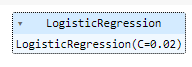

In [ ]:
pred=clf.predict(X_test)

In [ ]:
print(accuracy_score(pred, y_test))

0.9019834165224757


In [ ]:
print ("\n Classification report : \n", classification_report(y_test, pred))

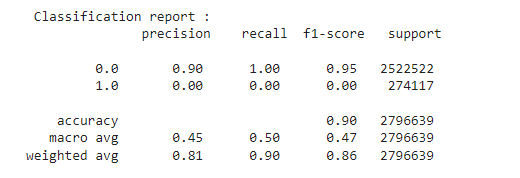

In [ ]:
f1 = f1_score(y_test, pred)
print("F1 Score: ", f1)

F1 Score:  0.0


In [ ]:
model_roc_auc = roc_auc_score(y_test,pred)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,pred)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.figure(figsize=(12,12))
plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

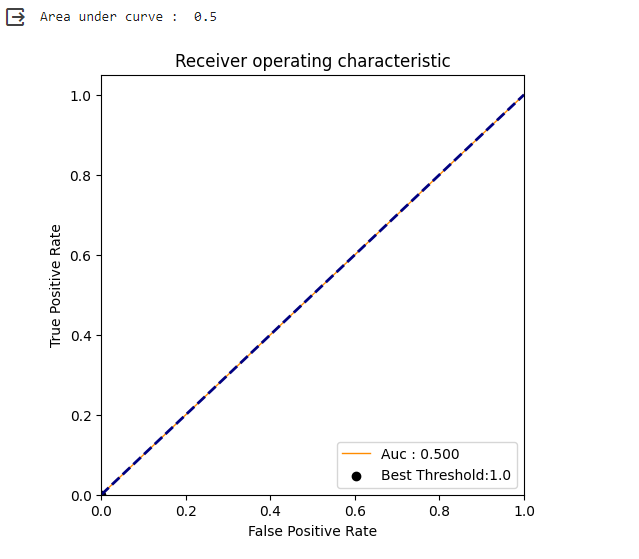

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
clfrf = RandomForestClassifier(max_features="log2", max_depth=11, n_estimators=24,min_samples_split=1000, oob_score=True)

In [ ]:
clfrf.fit(X_train, y_train)

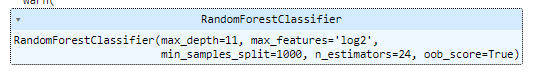

In [ ]:
predrf=clfrf.predict(X_test)

In [ ]:
accuracy_score(predrf, y_test)

0.9054708169341842

In [ ]:
print ("\n Classification report : \n", classification_report(y_test, predrf))


 Classification report : 
               precision    recall  f1-score   support

         0.0       0.91      0.99      0.95   2522522
         1.0       0.60      0.10      0.18    274117

    accuracy                           0.91   2796639
   macro avg       0.76      0.55      0.56   2796639
weighted avg       0.88      0.91      0.87   2796639



In [ ]:
f1 = f1_score(y_test, predrf)
print("F1 Score: ", f1)

F1 Score:  0.1760870649247033


In [ ]:
model_roc_auc = roc_auc_score(y_test,predrf)
print ("Area under curve : ",model_roc_auc,"\n")
fpr,tpr,thresholds = roc_curve(y_test,predrf)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix],3)

plt.figure(figsize=(12,12))
plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label = "Auc : %.3f" %model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

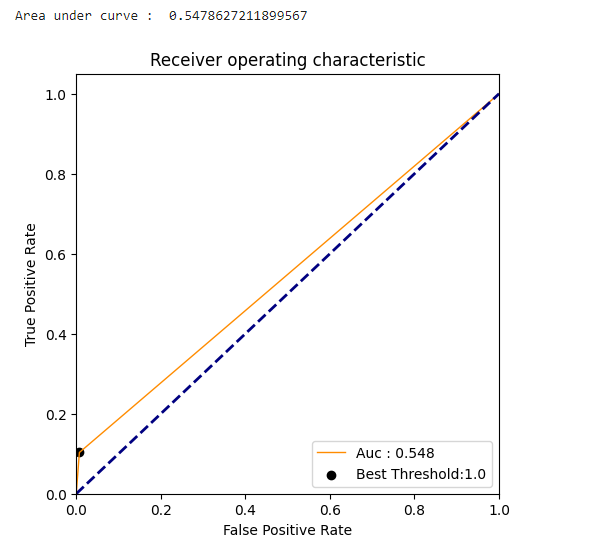